### Сборный проект. Поиск закономерностей для определения успешности игры

В этом проекте мы работаем в интернет-магазине «Стримчик», который продаёт компьютерные игры. Нам предоставлена выборка об исторических продажах игр из открытых источников. В рамках проекта нужно найти закономерности для определения успешности игр для планирования бюджета рекламной компании на 2017г.



### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

In [2]:
games = pd.read_csv('/datasets/games.csv')
print(games.head(5))
games.info()

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 

Нам были предоставлены исторические данные  о выпущенных играх. Данные содержат 11 столбцов и 16 715 строк. дубликатов на данном этапе не обнаружено.

В колонке Name представлены названия игр, некоторые из них относятся к одной игре, но разным выпускам по годам, тематике и т.д.
Формат переменных корректный, но в 2 строках пропущены значения по названию и жанру, в дальнейшем предлагаю эти строки удалить, т.к. эти данные мы не можем установить, а они критичны для исследования.

В колонке платформа представлены названия платформ, на которых были выпущены игры, формат переменной корректный, пропусков нет. В дальнейшем, возможно, нужно будет провести категоризацию, т.к. названия могут относится к одной платформе, но разным версиям (Playstation 2, Playstation 3 как пример).

В столбце Year_of_release представлены данные по году выпуска. В дальнейшем их нужно будет привести к целочисленному формату, т.к. для переменной, измеряющейся в года он подоходит больше. В 269 строках пропущен год, что составляет 1.6% от выборки. Нужно будет просмотреть их подробнее и решить, что делать с пропусками: удалять или заполнять.

В столбце genre указаны жанры игр. Формат данных корректен, есть 2 пропуска, которые будут удалены далее.

В колонках NA_sales, EU_sales, JP_sales и Other_sales приведены данные по продажам в млн.долларов, пропусков нет, тип данных float. Возможно их стоит перевести в целочисленный формат или, например, до 1 знака после запятой.

В столбце Critic_score указан рейтинг критиков, он не заполнен в примерно в 50% записей. Предлагаю далее эту колонку не трогать,так как, как мне кажется, эти пропуски довольно логичны: критики оценивают не все игры и это субъективная оценка, поэтому я не вижу смысла заполнять этот столбец в части пропусков.

В столбце User_score указан рейтинг пользователей, он также не заполнен в 40% записей. Здесь мне непонятен механизм появления пропусков и в реальной жизни я бы уточнила причину этих пропусков. Как я вижу, это может быть из-за следующих причин: какие-то платформы не раскрывают эти сведения, не во всех платформах есть такой функционал, данные берутся с какого-то конкретного публичного сайта, где представлено не все и т.д. 

В столбце rating в половине строк отсутствует рейтинг, формат столбца корректен. Возможно, причины пропуска: в открытых данных рейтинг не публикуется, игра продается в странах, где не нужно получать этот рейтинг. Оставим этот столбец далее без изменений.

### Шаг 2. Подготовьте данные.

In [3]:
games_clear = games
games_clear.columns = [str(i).lower() for i in games.columns]
games_clear.dropna( subset = ['name'], inplace = True)
games_clear.dropna( subset = ['year_of_release'], inplace = True)
games_clear['year_of_release'] = games['year_of_release'].astype('int')

games_clear['total_sales'] = games['na_sales']+ games['eu_sales'] + games['jp_sales'] + games['other_sales']

Были проведены следующие изменения:
1. Названия столбцов были переведены к нижнему регистру;
2. Были удалены строки с пустыми значениями по году и названию игры/жанру, количество удаленных записей составило ~1.6% от общей выборки.
Данные были удалены по следующим причинам:
а) Строки с отсутствующими данными о названии игры и жанре похожи на какие-то ошибки: записи всего две при общей выборке в 16 тысяч, возможно, это были какие-то тестовые строки в настройках выгрузки.
б) В пропусках в части года выпуска данных не прослеживается какая-то закономерность. По единичным записям, где в названии указан предположительно год, можно попробовать восстановить его, но это также может быть некорректным способом , т.к. могут выпускать игры с маркировкой 2014 в 2013 году или цифра в названии может не иметь отношению к фактическому году выпуска.
Так как общее количество строк с пропущенным названием или годом составило 270 строк из 16 714  и нам не у кого уточнить возможность возникновения пропусков, для дальнейшего исследования я удалила строки.
3. столбец с годом выпуска был переформатирован в целочисленный формат.
4. Добавлена колонка с суммой всех продаж.


Пропуски в колонках critic_score, user_score, rating не заполнялись. Так как:
1. Пропуски носят системный характер в случае с critic_score - критики оценивают не все игры, user_score - данные могут не публиковаться по каким- то платформам или исторически они собирались не всем играм, rating - получение рейтинга необязательно для продаж не в США.
2. Оценки пользователей и критиков носят субъективный характер и впечатления от игр нельзя как-то оцифровать и привести к стандартным критериям, поэтому я не стала заполнять пустые данные в этих столбцах.
3. Столбец с рейтингом я также не стала заполнять, так как эти рейтинги уже относятся к формальным законодательным требованиям и в формате таблицы нет возможности оценить какие игры подходят для детей, а какие только для взрослых.

In [4]:
print(games_clear.query('user_score =="tbd"').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'count'))

games_clear['user_score'] = games_clear['user_score'].replace("tbd", )

games_clear['user_score'] = games_clear['user_score'].astype('float')
print(games_clear.info())

                 total_sales
year_of_release             
1997                       1
1999                       8
2000                      43
2001                      82
2002                     192
2003                      95
2004                     107
2005                     121
2006                     124
2007                     192
2008                     326
2009                     405
2010                     331
2011                     217
2012                      24
2013                      15
2014                      21
2015                      38
2016                      34
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null f

Примерно в 1400 строках в столбце user_score была проставлена аббревиатура tbd, что означает "Будет определен позднее". Такой комментарий стоит по многим играм и предположение о том, что данные относятся к новым играм, не подтвердилось. Так как мы не можем ничего сказать о рейтинге игр с комментарием tbd среди пользователей, по факту, эти данные получается также не заполнены как и игры с отсутствующим рейтингом, поэтому эту аббревиатуру я заменила на пустые значения и далее столбец был переведен в формат float.

### Шаг 3. Проведите исследовательский анализ данных.

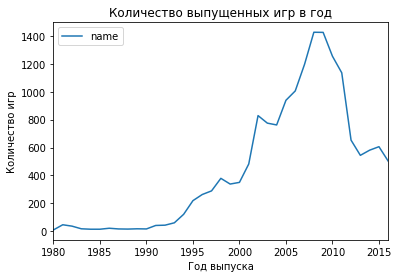

In [5]:
games_clear.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').plot();
plt.title("Количество выпущенных игр в год");
plt.xlabel('Год выпуска');
plt.ylabel('Количество игр');

На данном графике и в сводной таблице мы видим большой скачок в выпуске новых игр с 2000 по 2009 год, после чего идет падение в количестве выпущенных игр. 
Определенно мы можем использовать не все периоды, так как игры могут устаревать и очевидно, что сейчас люди не покупают и не играют в игры, выпущенные, например, до 2000года. НО пока по этому графику нельзя однозначно сказать игры какого периода мы можем использовать, а какого нет. Проанализируем далее продажи на разных платформах.


In [6]:
print(games_clear.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False))


          total_sales
platform             
PS2           1233.56
X360           961.24
PS3            931.34
Wii            891.18
DS             802.78
PS             727.58
PS4            314.14
GBA            312.88
PSP            289.53
3DS            257.81
PC             255.76
GB             254.43
XB             251.57
NES            251.05
N64            218.01
SNES           200.04
GC             196.73
XOne           159.32
2600            86.48
WiiU            82.19
PSV             53.81
SAT             33.59
GEN             28.35
DC              15.95
SCD              1.86
NG               1.44
WS               1.42
TG16             0.16
3DO              0.10
GG               0.04
PCFX             0.03


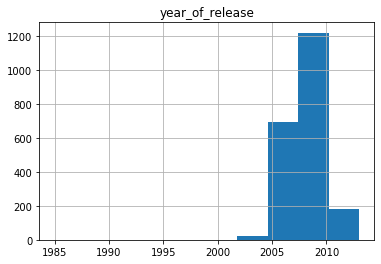

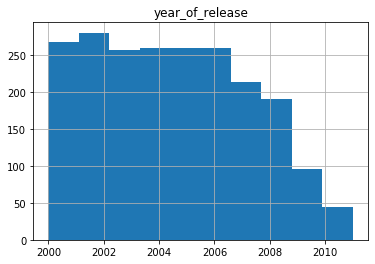

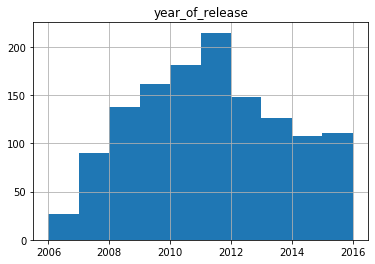

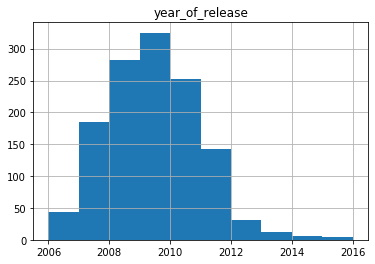

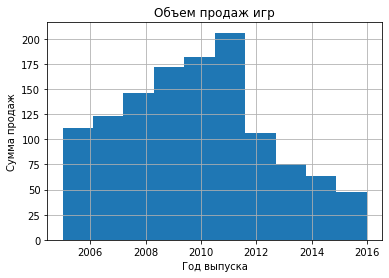

In [7]:
top_platform_games = games_clear.query('platform == "PS2" or platform == "X360" or platform == "PS3" or platform == "Wii" or platform == "DS"')

top_platform_games.groupby('platform').hist(column = 'year_of_release');
plt.title("Объем продаж игр");
plt.xlabel('Год выпуска');
plt.ylabel('Сумма продаж');


Я подготовила гистограммы распределения продаж по платформам, продажи на которых суммарно составили свыше 500 млн.долл.

Из этих графиков мы видим, что цикл "жизни" одной платформы составляет 10-11 лет, причем через 5 лет после запуска начинается спад продаж на платформе. Поэтому для дальнейшего анализа мы можем отобрать игры с годом выпуска не ранее 2013 года выпуска.

In [8]:
games_actual = games_clear.query('year_of_release >=2013 and platform !="DS" and platform!="PSP" and platform !="Wii"')
games_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 16 to 16714
Data columns (total 12 columns):
name               2135 non-null object
platform           2135 non-null object
year_of_release    2135 non-null int64
genre              2135 non-null object
na_sales           2135 non-null float64
eu_sales           2135 non-null float64
jp_sales           2135 non-null float64
other_sales        2135 non-null float64
critic_score       990 non-null float64
user_score         1219 non-null float64
rating             1228 non-null object
total_sales        2135 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 216.8+ KB


Мы отфильтровали для дальнейшего анализа игры с выпуском не ранее 2013 года, также я убрала платформы PSP и Wii, так как хоть по ним и были продажи в 2013 году, к 2016 году релизов на эти платформы не было, соответственно для планирования на 2017 год эти данные не актуальны.

In [9]:
print(games_actual.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False))
print(games_actual.pivot_table(index = 'platform',columns = 'year_of_release', values = 'total_sales', aggfunc = 'sum'))

          total_sales
platform             
PS4            314.14
PS3            181.43
XOne           159.32
3DS            143.25
X360           136.80
WiiU            64.63
PC              39.43
PSV             32.99
year_of_release    2013    2014    2015   2016
platform                                      
3DS               56.57   43.76   27.78  15.14
PC                12.38   13.28    8.52   5.25
PS3              113.25   47.76   16.82   3.60
PS4               25.99  100.00  118.90  69.25
PSV               10.59   11.90    6.25   4.25
WiiU              21.65   22.03   16.35   4.60
X360              88.58   34.74   11.96   1.52
XOne              18.96   54.07   60.14  26.15


Из сводных таблиц выше мы можем сделать следующие выводы:
1. Самые популярные платформы, на которые приходится ~87% всех продаж: PS4, PS3, XOne,3DS, X360;
2. Продажи по платформам 3DS, X360б PSV, WiiU идут на спад, но  по ней еще можно ожидать продажи в 2017г.;
3. Игры на PC не укладываются в теорию о сроке жизни платформы 10-11 лет и это можно объяснить логически: PC - персональные компьютеры, где гораздо большая вариативность техники и другая концепция его использования, много разных производителей и разные цели его использования (работа, учеба, игры и т.д.);
4. На смену PS3 была выпущена PS4, но по играм на PS3 еще можно ожидать продажи в 2017 году. Также можно предположить, что поведение пользователей этих платформ похоже, т.к. по сути это разные версии одной платформы.

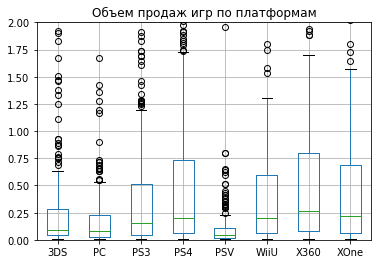

In [10]:
games_actual.pivot_table(index='name', columns='platform', values='total_sales', aggfunc='sum').boxplot()
plt.ylim(0, 2.0)
plt.title("Объем продаж игр по платформам");

На графике мы видим, что самые популярные платформы делятся на две большие группы: Playstation и Xbox, которые периодически выпускают новые версии, но общий объем продаж в сравнении с остальными платформами существеннен.

Также мы видим, что среди платформ больше пользуются успехом приставки к телевизору (формат игр на PC и PSV имеет гораздо меньший объем продаж в целом).

Коэффициент корреляции между общими продажими и оценками критиков: 0.406567902061781


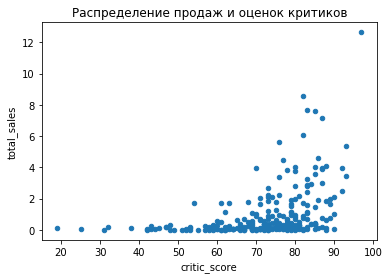

In [19]:
games_actual_ps4 = games_actual.query('platform == "PS4"')

games_actual_ps4.plot(x = 'critic_score', y ='total_sales',kind='scatter')
plt.title("Распределение продаж и оценок критиков");
print("Коэффициент корреляции между общими продажими и оценками критиков:",games_actual_ps4['total_sales'].corr(games_actual_ps4['critic_score']))

Была выявлена слабая прямая связь между объемом продаж и оценками критиков, если мы возьмем весь массив игр на ps4. То есть мы не можем сказать, что высокие оценки критиков способствуют росту продаж на PS4.

Коэффициент корреляции между общими продажими и оценками пользователей: -0.027427851974847168


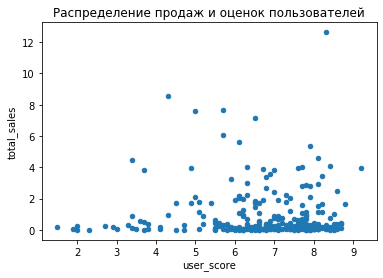

In [20]:
games_actual_ps4.plot(x = 'user_score', y ='total_sales',kind='scatter')
plt.title("Распределение продаж и оценок пользователей");
print("Коэффициент корреляции между общими продажими и оценками пользователей:",games_actual_ps4['total_sales'].corr(games_actual_ps4['user_score']))

Связи между оценками пользователей и объемом продаж нет. Возможно, это связано с тем, что у нас неполные данные по столбцу user_score.

In [13]:
print(games_actual.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by = 'total_sales', ascending = False))

              total_sales
genre                    
Action             317.69
Shooter            232.98
Sports             148.98
Role-Playing       144.86
Misc                55.51
Racing              39.89
Platform            39.69
Fighting            35.29
Adventure           22.72
Simulation          21.41
Strategy             9.80
Puzzle               3.17


К самым популярным жанрам мы можем отнести следующие: Action, Shooterk, Sports и Role_Playing. Наименее популярные - Strategy  и Puzzle. То есть можно сказать, что пользователи выбирают игры с высокой активностью, зачастую с соревновательным элементом.

### Шаг 4. Составьте портрет пользователя каждого региона.

              na_sales
genre                 
Action          124.35
Shooter         109.74
Sports           65.12
Role-Playing     46.40
Misc             24.00
Platform         16.72
Fighting         15.55
Racing           12.96
Adventure         7.10
Simulation        4.68
Strategy          3.13
Puzzle            0.83
          na_sales
platform          
PS4         108.74
XOne         93.12
X360         81.66
PS3          63.50
3DS          38.20
WiiU         29.21
PC           11.11
PSV           5.04
rating            E   E10+      M      T
genre                                   
Action         5.49  19.21  71.27  11.04
Adventure      0.31   0.88   2.90   0.21
Fighting        NaN   0.61   2.54   5.26
Misc           2.39   4.83   0.72   2.31
Platform       8.70   5.64    NaN   0.21
Puzzle         0.59   0.18    NaN    NaN
Racing         8.17   3.03   0.06   0.66
Role-Playing   0.68   0.86  16.67   6.03
Shooter         NaN   3.61  70.99  15.58
Simulation     1.05   0.53    NaN   1

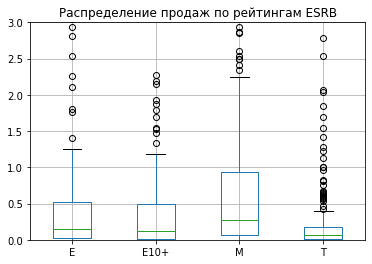

In [21]:
print(games_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by = 'na_sales', ascending = False))
print(games_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by = 'na_sales', ascending = False))
games_actual.pivot_table(index='name', columns='rating', values='na_sales', aggfunc='sum').boxplot()
plt.ylim(0, 3.0)
plt.title("Распределение продаж по рейтингам ESRB в Америке");
print(games_actual.pivot_table(index='genre', columns='rating', values='na_sales', aggfunc='sum'))

Пользователи Северной Америки предпочитают игры с маркировкой 18+, топ-5 жанров повторяют топ по всей выборке.
Объем продаж наибольший на платформе PS4 также как и во всей выборке.
Также мы видим, что большей популярностью пользуются игры с маркировкой 17+ (рейтинг M). Нельзя сказать, что рейтинг напрямую влияет на уровень продаж, скорее я бы сформулировала утверждение так: "игра, подходящая под критерии рейтинга M, будет пользоваться большей популярностью". Эти данные можно также соотнести с популярностью жанров, где у самых популярных жанров (Action и Shooter) большая часть продаж приходится на игры с рейтингом M.

              eu_sales
genre                 
Action          116.76
Shooter          87.86
Sports           59.60
Role-Playing     36.97
Racing           20.19
Misc             17.04
Platform         14.31
Simulation       10.78
Fighting          8.55
Adventure         8.09
Strategy          4.13
Puzzle            1.00
          eu_sales
platform          
PS4         141.09
PS3          67.81
XOne         51.59
X360         42.52
3DS          30.96
PC           25.36
WiiU         19.85
PSV           6.10


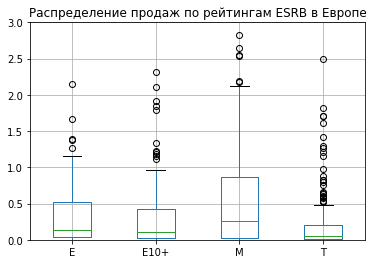

In [22]:
print(games_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by = 'eu_sales', ascending = False))
print(games_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by = 'eu_sales', ascending = False))
games_actual.pivot_table(index='name', columns='rating', values='eu_sales', aggfunc='sum').boxplot()
plt.ylim(0, 3.0)
plt.title("Распределение продаж по рейтингам ESRB в Европе");

Для пользователей Европы общая картина схожа с пользователями Северной Америки:
1. Самая популярная платформа - PS4,
2. топ-3 жанров совпадают;
3. Игры с рейтингом M имеют наибольший объем продаж, что также объяснимо жанровыми предпочтениями в регионе.

              jp_sales
genre                 
Role-Playing     50.01
Action           39.65
Misc              8.98
Fighting          7.63
Shooter           6.61
Adventure         5.11
Sports            4.91
Platform          4.79
Simulation        4.52
Racing            2.30
Strategy          1.75
Puzzle            1.18
          jp_sales
platform          
3DS          67.81
PS3          23.35
PSV          18.59
PS4          15.96
WiiU         10.88
X360          0.51
XOne          0.34
PC            0.00
rating           E  E10+     M      T
genre                                
Action        3.07  1.08  7.54   5.25
Adventure     0.53  0.00  0.42   0.03
Fighting       NaN  0.17  0.02   2.53
Misc          1.97  0.10  0.18   0.87
Platform      3.43  0.71   NaN   0.03
Puzzle        0.26  0.25   NaN    NaN
Racing        1.89  0.14  0.00   0.03
Role-Playing  0.39  1.08  2.51  10.67
Shooter        NaN  1.55  3.44   0.81
Simulation    1.42  0.43   NaN   0.18
Sports        2.04  0.09   NaN  

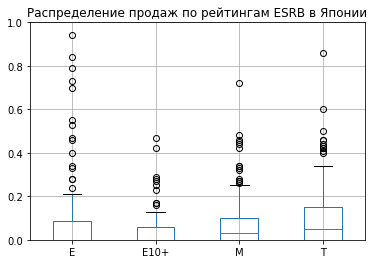

In [23]:
print(games_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by = 'jp_sales', ascending = False))
print(games_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by = 'jp_sales', ascending = False))
games_actual.pivot_table(index='name', columns='rating', values='jp_sales', aggfunc='sum').boxplot()
plt.ylim(0, 1.0)
print(games_actual.pivot_table(index='genre', columns='rating', values='jp_sales', aggfunc='sum'))
plt.title("Распределение продаж по рейтингам ESRB в Японии");

Портрет среднего пользователя Японии сильно отличается от пользователей Северной Америки и Европы.
1. Самая популярная платформа 3DS, продажи по которой в два раза больше, чем в Северной Америке или Европе;
2. 2 самых популярных жанра Role playing (в Европе и Америке на 4-ом месте) и action (самый популярный в других странах).
3. Фактор влияния рейтинга нельзя определить, т.к. по меньшая часть проданных игр имеет маркировку. Можно предположить, что большая часть продаваемых игр в Японии, выпускается под местные требования и маркировки рейтинга по стандартам ESRB не требуется.

На основе данных выше, мы можем сделать вывод, что поведение пользователей в Северной Америке и Европе очень похоже, поведение пользователей в Японии имеет свою специфику, при этом объем рынка в несколько раз ниже чем в Северной Америке и Европе.


### Шаг 5. Проверьте гипотезы

count    185.000000
mean       6.524865
std        1.372925
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

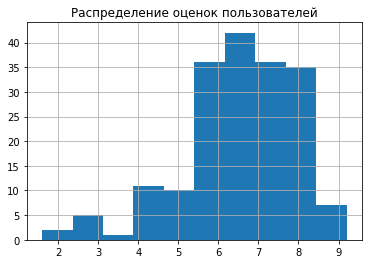

In [61]:
games_actual_xbox = games_actual.query('platform =="XOne"')


games_actual_xbox['user_score'].hist(bins = 10);
plt.title("Распределение оценок пользователей");
games_actual_xbox['user_score'].describe()

count    156.000000
mean       6.282692
std        1.744343
min        1.400000
25%        5.300000
50%        6.800000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64

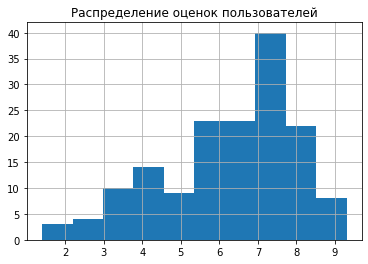

In [62]:
games_actual_pc = games_actual.query('platform =="PC"')
games_actual_pc['user_score'].hist(bins = 10)
plt.title("Распределение оценок пользователей");
games_actual_pc['user_score'].describe()

In [51]:
alpha = .05

results = st.ttest_ind(games_actual_xbox['user_score'], games_actual_pc['user_score'])


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


Не получилось отвергнуть нулевую гипотезу
          user_score
platform            
3DS         6.746237
PC          6.282692
PS3         6.378571
PS4         6.737452
PSV         7.490099
WiiU        7.020988
X360        6.001351
XOne        6.524865


Распределения величин достаточно похожи, выборки по большей части находятся в одном диапазоне, при этом, стандартное отклонение у рейтинга игр на PC больше, чем у XOne, как и дисперсия. Эту тенденцию мы также видим на гистограммах, где у XOne распределение достаточно приближено к нормальному распределению за исключением небольших выбросов слева, в то время как у PC более ломанные линии на гистограмме и сильное смещение вправо. За счет сильных отклонений в распределении в крайних диапазонах возьмем альфа-критерий 5%.

<font color=black>По заданию нам необходимо проверить гипотезу, что средний пользовательский рейтинг платформ Xbox One и PC одинаков.
Сформулируем следующие гипотезы:

H0: Average user score(PC) == Average user score(XOne)

H1: Average user score(PC) != Average user score(XOne)

С точки зрения определения метода:
    
1. Мы проверяем разницу наших средних между двумя платформами
2. Количество объектов в наших выборках больше 100


Гипотеза о равенстве среднего пользовательского рейтинга с 95% подтверждена и мы можем сделать вывод что в целом распределение рейтингов на этих платформах существенно не отличается.

count    403.000000
mean       6.810422
std        1.377896
min        2.000000
25%        6.300000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

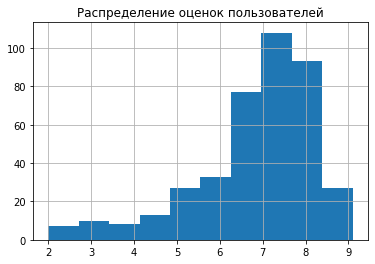

In [47]:
games_actual_action = games_actual.query('genre =="Action"')
games_actual_action['user_score'].hist();
plt.title("Распределение оценок пользователей");
games_actual_action['user_score'].describe()


count    161.000000
mean       5.314907
std        1.819279
min        0.200000
25%        4.100000
50%        5.600000
75%        6.600000
max        9.300000
Name: user_score, dtype: float64

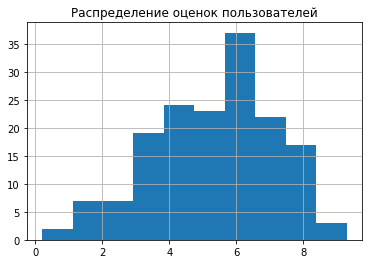

In [48]:
games_actual_sports = games_actual.query('genre =="Sports"')
games_actual_sports['user_score'].hist();
plt.title("Распределение оценок пользователей");
games_actual_sports['user_score'].describe()

In [66]:
alpha = .05

results = st.ttest_ind(games_actual_action['user_score'], games_actual_sports['user_score'])

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print(games_actual.pivot_table(index = 'genre', values = 'user_score', aggfunc = 'mean'))  

Не получилось отвергнуть нулевую гипотезу
              user_score
genre                   
Action          6.810422
Adventure       7.313846
Fighting        7.018367
Misc            6.970370
Platform        6.653448
Puzzle          7.471429
Racing          6.144776
Role-Playing    7.369630
Shooter         6.312579
Simulation      6.125000
Sports          5.314907
Strategy        6.300000


Здесь уже достаточно разная картина по распределениям, объяснить это можно тем, что наблюдений в выборке по жанру Action в 2.5 раза больше, соотвественно и диапазон, и распределение из-за этого сильно отличаются. Оба распределения смещены вправо, но из-за большего числа наблюдений у жанра Action левый хвост длиннее, чем у Sports. Возьмем также уровень альфа-критерий 5%, т.к.  уровень выше нас не устроит, а для 1% у нас достаточно разнородные выборки.<font color=blue/>

<font color=black>По заданию нам необходимо проверить гипотезу, что средний пользовательский рейтинг жанров Action и Sports одинаков.
Сформулируем следующие гипотезы:

H0: Average user score(Action) == Average user score(Sports)

H1: Average user score(Action) != Average user score(Sports)

с 95% вероятностью гипотеза о том, что средние пользовательские равны подтверждена, соответственно мы не можем сказать, что рейтинги жанров Action и Sports отличаются.

### Шаг 6. Общий вывод

На основании анализа выше мы можем сделать следующие выводы:
1. в 2017 году стоит концентрироваться на релизах для PS4, XOne и 3DS, по ним можно ожидать наибольшие продажи.
2. Приоритетные жанры для рекламной компании: Action, Shooter, Sport, Role-play, особое внимание следует обратить на жанры с маркировкой М;
3. Для Японии рейтинг ESRB не является маркером больших продаж, т.к. предположительно, он там не используется.
4. Рейтинги пользователей и критиков не несут существенного влияния на объем продаж, но какие-то смежные с ними показатели (количество материалов об игре, просмотров трейлеров/пресс-релизов) могут дать больше информации о влиянии.

Для улучшения анализа в дальнейшем, было бы неплохо узнать почему есть данные пользовательского рейтинга и оценки критиков не по всем играм: возможно, это техническая ошибка сбора данных (данные не подкачиваются из каких-то источников) или мы собираем данные не по всем публично открытым источникам.